In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Input,Dropout
import tensorflow.keras.backend as K
from keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

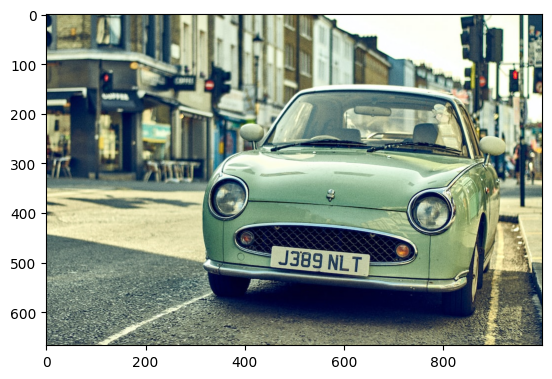

In [27]:
image = cv2.imread('car4.jpeg')

# Check if the image is loaded successfully
if image is not None and image.size != 0:
    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Error: Unable to load or empty image.")

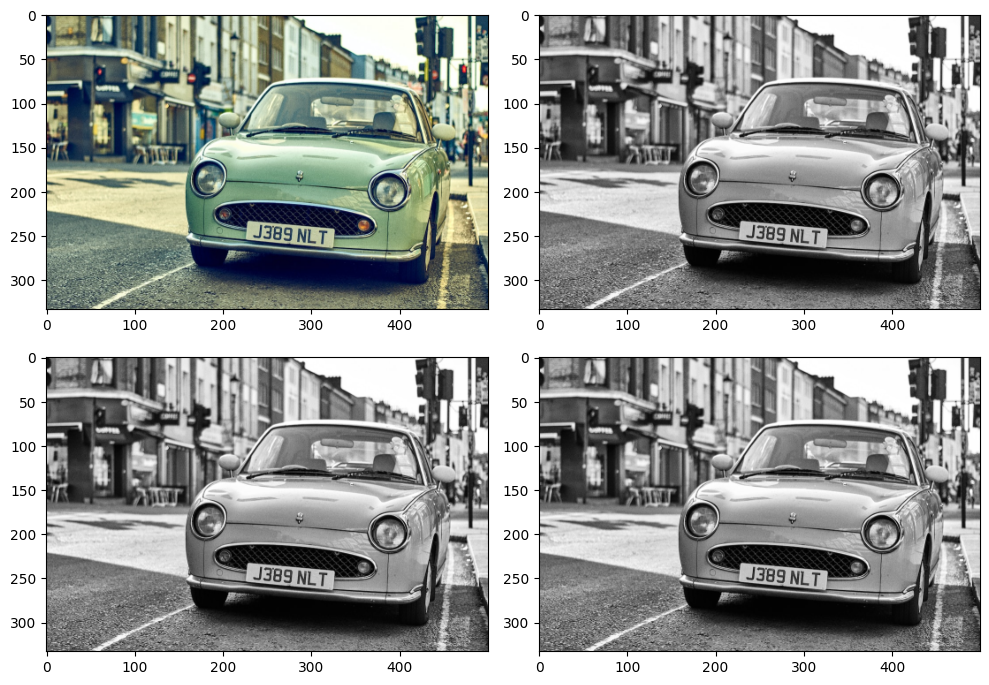

In [5]:
image=imutils.resize(image, width=500)
img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#DISPLAY ORIGINAL IMAGE
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

#convert into gray image
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')

#noise removal from image
bf=cv2.bilateralFilter(gray,11,17,17)
ax[1,0].imshow(gray, cmap='gray')

#find the edge
edged=cv2.Canny(bf,30,200)
ax[1,1].imshow(gray, cmap='gray')

fig.tight_layout()
plt.show()


In [6]:
keypts= cv2.findContours(edged.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
cnt= imutils.grab_contours(keypts)
cnt=sorted(cnt,key=cv2.contourArea, reverse=True)[:10]
Location=None

#loop over our countour to find the best possible approx countour number plate
count=0
for c in cnt:
    approx=cv2.approxPolyDP(c,10,True)
    print(len(approx))
    if len(approx) == 4:
        Location=approx
        break

5
32
41
4


In [7]:
print(Location)

[[[227 235]]

 [[324 241]]

 [[325 261]]

 [[227 254]]]


In [8]:
mask=np.zeros(gray.shape,np.uint8)
new_img=cv2.drawContours(mask,[Location],0,255,-1)
new_img=cv2.bitwise_and(image,image,mask=mask)

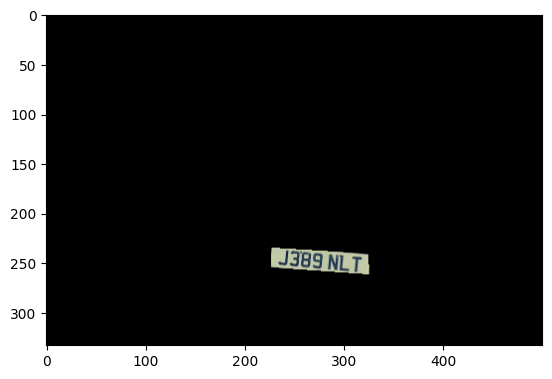

In [9]:
plt.imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))

In [10]:
(x,y)=np.where(mask==255)
(x1,y1)=(np.min(x),np.min(y))
(x2,y2)=(np.max(x),np.max(y))
cropped_img=gray[x1:x2+1,y1:y2+1]

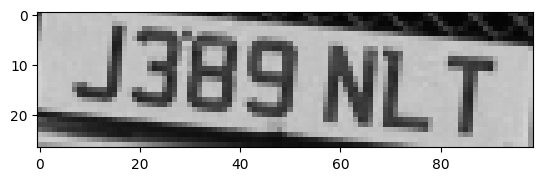

In [11]:
plt.imshow(cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB))

In [12]:
cv2.imwrite('cropped_plate.jpg',cropped_img)

True

# character segmentation

In [13]:
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []

    for cntr in cntrs:
        # Detects contour in binary image and returns the coordinates of the enclosing rectangle
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # Calculate the aspect ratio
        aspect_ratio = float(intWidth) / intHeight

        # Check if the aspect ratio is within the acceptable range
        min_aspect_ratio = 0.2  # Adjust as needed
        max_aspect_ratio = 1.0  # Adjust as needed

        if min_aspect_ratio < aspect_ratio < max_aspect_ratio:
            # Character aspect ratio is within the acceptable range

            x_cntr_list.append(intX)  # Stores the x-coordinate of the character's contour for sorting

            char_copy = np.zeros((44, 24))
            # Extracting each character using the enclosing rectangle's coordinates
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with a black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Sorting characters based on x-coordinate
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # Stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


In [14]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    if len(img_lp.shape) == 3 and img_lp.shape[2] == 3:
        # Convert BGR image to grayscale
        img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
        print("yes!!!")
    elif len(img_lp.shape) == 2:
        # Input image is already in grayscale, no need for conversion
        img_gray_lp = img_lp
        print("yes2!!!")
    else:
        # Handle unsupported image format
        raise ValueError("Unsupported image format. Expected BGR or grayscale image.")

    plt.imshow(img_gray_lp, cmap='gray')
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    print(dimensions)
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

yes2!!!
[12.5, 37.5, 33.3, 222.0]


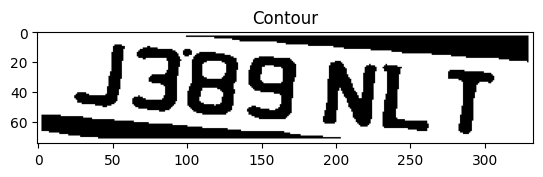

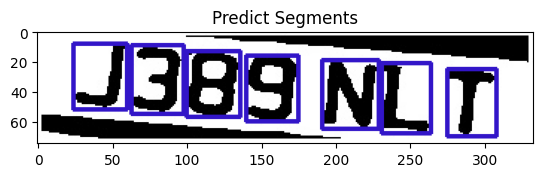

In [15]:
char=segment_characters(cropped_img)

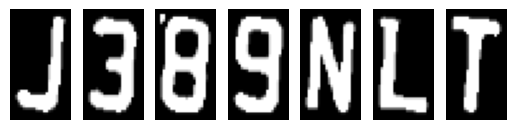

In [16]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [17]:
train_datagen=ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path='dataset/data'
train_generator=train_datagen.flow_from_directory(
    path+'/train',
    target_size=(28,28),
    batch_size=1,
    class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
    path+'/val',
    target_size=(28,28),
    batch_size=1,
    class_mode='sparse')

Found 1561 images belonging to 36 classes.
Found 407 images belonging to 36 classes.


In [18]:
K.clear_session()
model=Sequential()
model.add(Conv2D(16,(22,22),input_shape=(28,28,3),activation='relu',padding='same'))
model.add(Conv2D(32,(16,16),input_shape=(28,28,3),activation='relu',padding='same'))
model.add(Conv2D(64,(8,8),input_shape=(28,28,3),activation='relu',padding='same'))
model.add(Conv2D(64,(4,4),input_shape=(28,28,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(36,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=0.0001),metrics='accuracy')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [76]:
batch_size=1
result=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,
    validation_data=validation_generator,
    epochs=10,verbose=1,callbacks=None)

Epoch 1/10
1561/1561 [==============================] - 55s 35ms/step - loss: 3.3065 - accuracy: 0.1057 - val_loss: 2.7902 - val_accuracy: 0.2432
Epoch 2/10
1561/1561 [==============================] - 53s 34ms/step - loss: 2.2286 - accuracy: 0.3664 - val_loss: 2.3247 - val_accuracy: 0.3710
Epoch 3/10
1561/1561 [==============================] - 53s 34ms/step - loss: 1.9186 - accuracy: 0.4696 - val_loss: 2.1487 - val_accuracy: 0.4029
Epoch 4/10
1561/1561 [==============================] - 53s 34ms/step - loss: 1.7635 - accuracy: 0.5157 - val_loss: 1.9894 - val_accuracy: 0.4693
Epoch 5/10
1561/1561 [==============================] - 53s 34ms/step - loss: 1.6297 - accuracy: 0.5484 - val_loss: 1.8638 - val_accuracy: 0.4767
Epoch 6/10
1561/1561 [==============================] - 53s 34ms/step - loss: 1.4698 - accuracy: 0.5650 - val_loss: 1.5926 - val_accuracy: 0.4939
Epoch 7/10
1561/1561 [==============================] - 53s 34ms/step - loss: 1.1895 - accuracy: 0.6316 - val_loss: 1.3172 -

In [20]:
def load_and_preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image to the required input size (28, 28) for your model
    image = cv2.resize(image, (28, 28))

    # Perform any other preprocessing steps if needed (e.g., normalization)

    return image

NameError: name 'result' is not defined

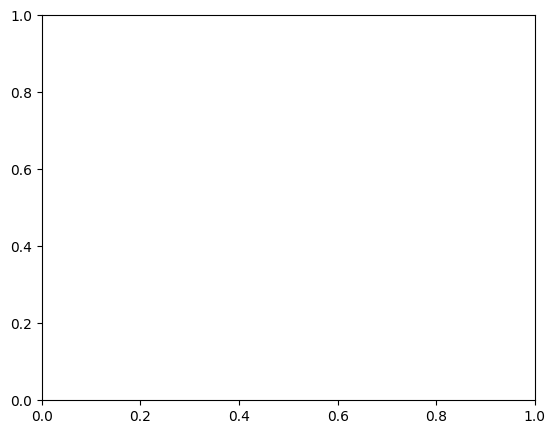

In [19]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [79]:
model.save_weights('model')

In [21]:
#Since we saved only the model weights, we first need to create a model instance and then load the saved weights into the model.

# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('model')

Predict the license plate number

In [22]:
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_probs = loaded_model.predict(img)[0]  # predicting class probabilities
        y_ = np.argmax(y_probs)  # finding the index of the maximum probability
        character = dic[y_]  # use the index as a key
        output.append(character)  # storing the result in a list

    plate_number = ''.join(output)
    return plate_number

des=show_results()
print(des)


1/1 [==============================] - 0s 50ms/step
J389NLT


1/1 [==============================] - 0s 48ms/step


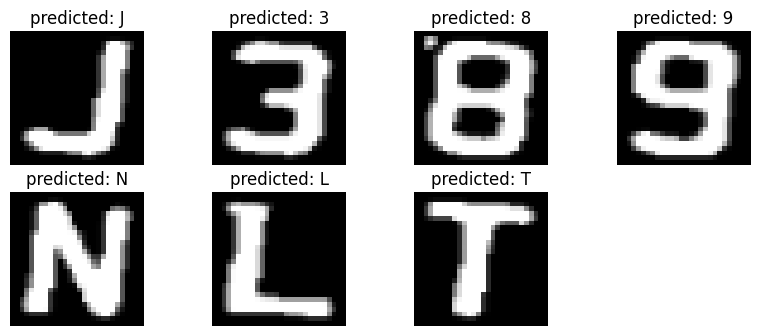

In [23]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Assuming len(char) == 13
for i, ch in enumerate(char):
    img = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
    plt.subplot(4, 4, i + 1)  # Adjusted to a 4x4 grid
    plt.imshow(img, cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')

plt.show()


In [24]:
import pyttsx3

def speak_text(text):
    # Initialize the text-to-speech engine
    engine = pyttsx3.init()

    # Set properties (optional)
    engine.setProperty('rate', 100)  # Speed of speech

    # Say the given text
    engine.say(text)

    # Wait for the speech to finish
    engine.runAndWait()

In [25]:
speak_text(des)

In [85]:
from gtts import gTTS
import pygame
import os

def text_to_speech(text,language='en',output_file='output.mp3'):
    tts=gTTS(text=text,lang=language,slow=False)
    tts.save(output_file)
    os.system(f'output')

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [86]:
text_to_speech(des)